Here's an example where we run an algorithm with zipline, then produce tear sheets for that algorithm.

In [1]:
%matplotlib inline
import zipline
import pandas as pd

print "zipline {0}".format(zipline.__version__)
print "pandas {0}".format(pd.__version__)

zipline 1.0.2
pandas 0.16.2


In [2]:
%%zipline --start=2011-1-1 --end=2013-1-1 -o perf

from zipline.api import order, record, symbol
import matplotlib.pyplot as plt

def initialize(context):
    pass

def handle_data(context, data):
    order(symbol('AAPL'), 10)
    record(AAPL=data[symbol('AAPL')].price)
    
def analyze(context, perf):
    ax1 = plt.subplot(211)
    perf.portfolio_value.plot(ax=ax1)
    ax2 = plt.subplot(212, sharex=ax1)
    perf.AAPL.plot(ax=ax2)
    plt.gcf().set_size_inches(18, 8)
    plt.show()

ERROR: Cell magic `%%zipline` not found.


In [3]:
# zipline + scrapy_giant + pyfolio

%matplotlib inline

# default lib import
import sys
import logbook
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from collections import deque
import pytz
import traceback

In [4]:
# pyfolio and zipline import
import pyfolio as pf

from zipline.algorithm import TradingAlgorithm
from zipline.api import (
    FixedSlippage,
    order,
    set_slippage,
    record,
    sid,
)
from zipline.utils.factory import load_from_yahoo
from zipline.finance import commission
from zipline.utils.factory import *
from zipline.finance.trading import SimulationParameters

In [5]:
STOCKS = ['AMD']
start = datetime.utcnow() - timedelta(days=20)
end = datetime.utcnow() - timedelta(days=10)
data = load_from_yahoo(stocks=STOCKS, indexes={}, start=start, end=end)
data = data.dropna()
print data.tail(4)

                            AMD
Date                           
2016-09-01 00:00:00+00:00  7.35
2016-09-02 00:00:00+00:00  7.51
2016-09-06 00:00:00+00:00  7.34
2016-09-07 00:00:00+00:00  6.84


/Users/seanchen/anaconda2/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


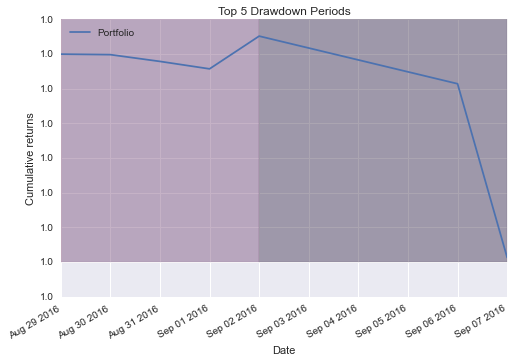

In [6]:
# Create and run the algorithm by calling func binded
def initialize(algo):
    algo.stock = 'AMD'
    algo.asset = algo.symbol(algo.stock)
    
def handle_data(algo, data):
    algo.order(algo.asset, 1000)
    
def_alg = TradingAlgorithm(handle_data=handle_data, initialize=initialize)
results = def_alg.run(data)
returns, positions, transactions, gross_lev = pf.utils.extract_rets_pos_txn_from_zipline(results)
pf.plot_drawdown_periods(returns, top=5).set_xlabel('Date')

In [7]:
STOCKS = ['2317.TW']
start = datetime.utcnow() - timedelta(days=20)
end = datetime.utcnow() - timedelta(days=10)
data = load_from_yahoo(stocks=STOCKS, indexes={}, start=start, end=end)
data = data.dropna()
print data.tail(4)

                           2317.TW
Date                              
2016-09-02 00:00:00+00:00     77.2
2016-09-05 00:00:00+00:00     78.3
2016-09-06 00:00:00+00:00     79.7
2016-09-07 00:00:00+00:00     79.6


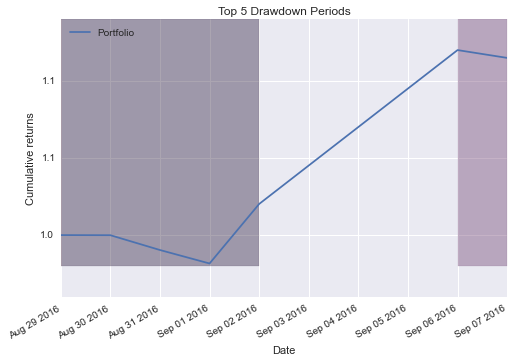

In [8]:
# extend basic alg to top
class TestAlgorithm(TradingAlgorithm):
    
    def __init__(self, *args, **kwargs):
        super(TestAlgorithm, self).__init__(args, kwargs)
        self.ssid = kwargs.pop('symbol', '2317.TW')
        self.amount = kwargs.pop('amount', 1000)

    def initialize(self, *args, **kwargs):
        super(TestAlgorithm, self).initialize(args, kwargs)
        self.asset = self.symbol(self.ssid)
    
    def handle_data(self, data):
        super(TestAlgorithm, self).handle_data(data)
        self.order(self.asset, self.amount)

test_alg = TestAlgorithm()
results = test_alg.run(data)
returns, positions, transactions, gross_lev = pf.utils.extract_rets_pos_txn_from_zipline(results)
pf.plot_drawdown_periods(returns, top=5).set_xlabel('Date')

In [9]:
# scrapy_giant import
import talib
import traceback
from IPython.display import display, HTML

from bin.mongodb_driver import *
from bin.start import *

from handler.tasks import collect_hisframe
from handler.hisdb_handler import TwseHisDBHandler, OtcHisDBHandler
from handler.iddb_handler import TwseIdDBHandler, OtcIdDBHandler

from algorithm.report import Report
from algorithm.register import AlgRegister

                           close  high   low  open  price  volume
2016-09-02 00:00:00+00:00   77.2  77.9  76.3  76.6   77.2  158664
2016-09-05 00:00:00+00:00   78.2  78.4  77.6  77.9   78.2   44625
2016-09-06 00:00:00+00:00   79.8  79.9  78.6  78.8   79.8   51022
2016-09-07 00:00:00+00:00   79.5  80.8  79.5  80.4   79.5   59399


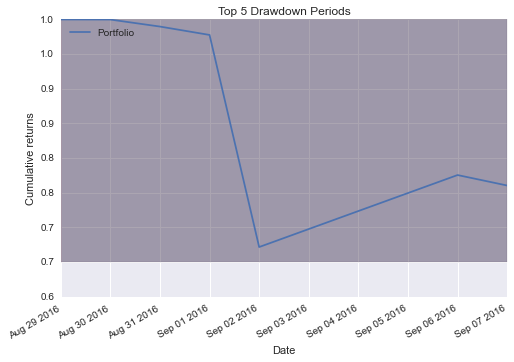

In [10]:
starttime = datetime.utcnow() - timedelta(days=20)
endtime = datetime.utcnow() - timedelta(days=10)
stockids = ['2317']

# use scrapy_giant as input 
kwargs = {
    'opt': 'twse',
    'targets': ['stock'],
    'starttime': starttime,
    'endtime': endtime,
    'stockids': stockids,
    'traderids': [],
    'base': 'stock',
    'callback': None,
    'limit': 1,
    'debug': True
}
panel, dbhandler = collect_hisframe(**kwargs)
print panel['2317'].tail(4) 

test_alg = TestAlgorithm(**{'symbol':'2317'})
results = test_alg.run(panel)
returns, positions, transactions, gross_lev = pf.utils.extract_rets_pos_txn_from_zipline(results)
pf.plot_drawdown_periods(returns, top=5).set_xlabel('Date')

In [11]:
class DualEMA(TradingAlgorithm):
    """ Dual Moving Average Crossover algorithm
    """

    def __init__(self, dbhandler, *args, **kwargs):
        self._debug = kwargs.pop('debug', False)
        self._cfg = {
            'buf_win': kwargs.pop('buf_win', 30),
            'buy_hold': kwargs.pop('buy_hold', 5),
            'sell_hold': kwargs.pop('sell_hold', 5),
            'buy_amount': kwargs.pop('buy_amount', 1000),
            'sell_amount': kwargs.pop('sell_amount', 1000),
            'short_ema_win': kwargs.pop('short_ema_win', 7),
            'long_ema_win': kwargs.pop('long_ema_win', 20),
            'trend_up': kwargs.pop('trend_up', True),
            'trend_down': kwargs.pop('trend_down', True)
        }
        super(DualEMA, self).__init__(*args, **kwargs)
        self.dbhandler = dbhandler
        self.sids = self.dbhandler.stock.ids
        
    @property
    def cfg(self):
        return self._cfg

    def initialize(self, *args, **kwargs):
        super(DualEMA, self).initialize(args, kwargs)        
        self.asset = self.symbol(self.sids[0]) 
        self.window = deque(maxlen=self._cfg['buf_win'])
        self.invested_buy = False
        self.invested_sell = False
        self.buy = False
        self.sell = False
        self.buy_hold = 0
        self.sell_hold = 0
        
    def handle_data(self, data):
        super(DualEMA, self).handle_data(data)
        self.window.append((
            data[self.asset].open,
            data[self.asset].high,
            data[self.asset].low,
            data[self.asset].close,
            data[self.asset].volume
        ))

        if len(self.window) == self._cfg['buf_win']:
            open, high, low, close, volume = [np.array(i) for i in zip(*self.window)]
            short_ema = talib.EMA(close, timeperiod=self._cfg['short_ema_win'])
            long_ema = talib.EMA(close, timeperiod=self._cfg['long_ema_win'])
            real_obv = talib.OBV(close, np.asarray(volume, dtype='float'))

            self.buy_hold = self.buy_hold - 1 if self.buy_hold > 0 else self.buy_hold
            self.sell_hold = self.sell_hold - 1 if self.sell_hold > 0 else self.sell_hold
            self.buy = False
            self.sell = False

            # sell after buy
            if self._cfg['trend_up']:
                if short_ema[-1] > long_ema[-1] and not self.invested_buy:
                    self.order(self.asset, self._cfg['buy_amount'])
                    self.invested_buy = True
                    self.buy = True
                    self.buy_hold = self._cfg['buy_hold']
                elif self.invested_buy == True and self.buy_hold == 0:
                    self.order(self.asset, -self._cfg['buy_amount'])
                    self.invested_buy = False
                    self.sell = True

            # buy after sell
            if self._cfg['trend_down']:
                if short_ema[-1] < long_ema[-1] and not self.invested_sell:
                    self.order(self.asset, -self._cfg['sell_amount'])
                    self.invested_sell = True
                    self.sell = True
                    self.sell_hold = self._cfg['sell_hold']
                elif self.invested_sell == True  and self.sell_hold == 0:
                    self.order(self.asset, self._cfg['sell_amount'])
                    self.invested_sell = False
                    self.buy = True

            # save to recorder
            signals = {
                'open': open[-1],
                'high': high[-1],
                'low': low[-1],
                'close': close[-1],
                'volume': volume[-1],
                'short_ema': short_ema[-1],
                'long_ema': long_ema[-1],
                'buy': self.buy,
                'sell': self.sell
            }
            self.record(**signals)

# register to alg tasks
AlgRegister.add(DualEMA)

In [14]:
def test_alg_benchmark(opt='twse', debug=True, limit=0):   
    maxlen = 10
    starttime = datetime.utcnow() - timedelta(days=60)
    endtime = datetime.utcnow() - timedelta(days=10)
        
    report = Report(
        'dualema',
        sort=[('buys', False), ('sells', False), ('portfolio_value', False)], limit=20)

    kwargs = {
        'debug': debug,
        'limit': limit,
        'opt': opt
    }
    # fetch all stockids
    idhandler = TwseIdDBHandler(**kwargs)
    stockids = [stockid for stockid in idhandler.stock.get_ids()]
    for stockid in stockids:
        try:
            kwargs = {
                'opt': opt,
                'targets': ['stock'],
                'starttime': starttime,
                'endtime': endtime,
                'stockids': [stockid],
                'traderids': [],
                'base': 'stock',
                'callback': None,
                'limit': 1,
                'debug': debug
            }
            panel, dbhandler = collect_hisframe(**kwargs)
            if len(panel[stockid].index) < maxlen:
                continue
           
            dualema = DualEMA(dbhandler=dbhandler, **{'symbol':stockid})
            results = dualema.run(panel)
            risks = dualema.perf_tracker.handle_simulation_end()  
            report.collect(stockid, results, risks)    
            
        except:
            print traceback.format_exc()
            continue
        
        return report

# run 
report = test_alg_benchmark()
pool = report.pool
results = pool['2317'].dropna()
HTML(results.to_html())

/Users/seanchen/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:40: ZiplineDeprecationWarning: `data[sid(N)]` is deprecated. Use `data.current`.
/Users/seanchen/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:41: ZiplineDeprecationWarning: `data[sid(N)]` is deprecated. Use `data.current`.
/Users/seanchen/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:42: ZiplineDeprecationWarning: `data[sid(N)]` is deprecated. Use `data.current`.
/Users/seanchen/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:43: ZiplineDeprecationWarning: `data[sid(N)]` is deprecated. Use `data.current`.
/Users/seanchen/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:44: ZiplineDeprecationWarning: `data[sid(N)]` is deprecated. Use `data.current`.


,algo_volatility,algorithm_period_return,alpha,benchmark_period_return,benchmark_volatility,beta,buy,capital_used,close,ending_cash,ending_exposure,ending_value,excess_return,gross_leverage,high,information,long_ema,long_exposure,long_value,longs_count,low,max_drawdown,max_leverage,net_leverage,open,orders,period_close,period_label,period_open,pnl,portfolio_value,positions,returns,sell,sharpe,short_ema,short_exposure,short_value,shorts_count,sortino,starting_cash,starting_exposure,starting_value,trading_days,transactions,treasury_period_return,volume
2016-08-31 20:00:00,0.000267,-0.000094,-0.000780,0.003314,0.053961,0.000672,False,-88009.357169,88.0,11990.642831,88000,88000,-0.015894,0.880082,88.9,-0.033949,87.764921,88000,88000,1,88.0,-0.000094,0,0.880082,88.7,"[{u'status': 1, u'created': 2016-08-30 20:00:0...",2016-08-31 20:00:00+00:00,2016-08,2016-08-31 13:31:00+00:00,-9.357169,99990.642831,"[{u'amount': 1000, u'last_sale_price': 88.0, u...",-0.000094,False,-2.851146,88.034565,0,0,0,-2.851146,100000.000000,0,0,31,"[{u'commission': None, u'amount': 1000, u'sid'...",0.0158,68836
2016-09-01 20:00:00,0.016833,-0.006094,-0.048079,0.003272,0.053086,0.003247,False,0.000000,87.4,11990.642831,87400,87400,-0.021794,0.879358,87.8,-0.085181,87.782064,87400,87400,1,86.8,-0.006094,0,0.879358,87.2,[],2016-09-01 20:00:00+00:00,2016-09,2016-09-01 13:31:00+00:00,-600.000000,99390.642831,"[{u'amount': 1000, u'last_sale_price': 87.4, u...",-0.006001,False,-2.851091,87.875938,0,0,0,-2.849657,11990.642831,88000,88000,32,[],0.0157,103889
2016-09-02 20:00:00,0.283553,-0.108094,-0.765027,0.007487,0.053460,-1.117295,False,0.000000,77.2,11990.642831,77200,77200,-0.124094,0.865562,77.9,-0.186950,86.826146,77200,77200,1,76.3,-0.108094,0,0.865562,76.6,"[{u'status': 0, u'created': 2016-09-02 20:00:0...",2016-09-02 20:00:00+00:00,2016-09,2016-09-02 13:31:00+00:00,-10200.000000,89190.642831,"[{u'amount': 1000, u'last_sale_price': 77.2, u...",-0.102625,True,-2.927926,85.207040,0,0,0,-2.922501,11990.642831,87400,87400,33,[],0.0160,158664
2016-09-06 20:00:00,0.292765,-0.082199,-0.522744,0.010491,0.053174,-0.862095,False,79789.434594,79.8,91780.077426,0,0,-0.097699,0.000000,79.9,-0.137959,86.203198,0,0,0,78.6,-0.108094,0,0.000000,78.8,"[{u'status': 1, u'created': 2016-09-02 20:00:0...",2016-09-06 20:00:00+00:00,2016-09,2016-09-06 13:31:00+00:00,2589.434594,91780.077426,[],0.029033,False,-2.017388,83.855552,0,0,0,-2.110337,11990.642831,77200,77200,34,"[{u'commission': None, u'amount': -1000, u'sid...",0.0155,51022
2016-09-07 20:00:00,0.288496,-0.082199,-0.508541,0.010343,0.052400,-0.864439,False,0.000000,79.5,91780.077426,0,0,-0.097599,0.000000,80.8,-0.135770,85.596830,0,0,0,79.5,-0.108094,0,0.000000,80.4,"[{u'status': 0, u'created': 2016-09-07 20:00:0...",2016-09-07 20:00:00+00:00,2016-09,2016-09-07 13:31:00+00:00,0.000000,91780.077426,[],0.000000,True,-1.988747,82.766822,0,0,0,-2.079971,91780.077426,0,0,35,[],0.0154,59399


In [ ]:
returns, positions, transactions, gross_lev = pf.utils.extract_rets_pos_txn_from_zipline(results)
pf.plot_drawdown_periods(returns, top=5).set_xlabel('Date')

In [ ]:
pf.create_full_tear_sheet(returns, positions=positions, transactions=transactions,
                          gross_lev=gross_lev, live_start_date='2016-08-31', round_trips=True)